In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pickle

import os
import re
from collections import OrderedDict

import seaborn as sns
sns.set_theme(font_scale=1.5);

In [3]:
Earray   = np.round(np.logspace(np.log10(0.250), np.log10(10000), 100), 2)
h        = np.linspace(0, 499, 500);
binWidth = np.hstack([np.diff(Earray), np.diff(Earray)[-1]]);

def ProcessIoniData(data):
    
    lineNo = 1000
    
    nRuns  = int(len(data)/lineNo)
    
    mean = np.zeros([1000])
    std  = np.zeros([1000])
    for i in range(0, nRuns):
        
        mean += data.E.values[i*lineNo:(i+1)*lineNo]
        
        std  += (data.E.values[i*lineNo:(i+1)*lineNo])**2
        
    std -= (mean/nRuns)**2
    
    std[std < 0] = 0
    
    std = np.sqrt(1/(nRuns-1) * std)
    
    return mean, std

def ProcessSpectralData(data):
    
    lineNo = 1000
    
    nRuns  = int(len(data)/lineNo)
    
    data.fillna(data.mean(), inplace=True)

    mean = np.zeros([lineNo, 100]);
    std  = np.zeros([lineNo, 100]);
    for i in range(0, nRuns):
        mean += data.values[lineNo*i:lineNo*(i+1), :]
        std  += (data.values[lineNo*i:lineNo*(i+1), :])**2
        
    std -= (mean/nRuns)**2
    
    std[std < 0] = 0
    
    std = np.sqrt(1/(nRuns-1) * std)
    
    return mean/binWidth, std/binWidth

From sin(a$\alpha$) from $\alpha \in [0, 45^\circ]$,

$$N_{n=1} = 2 \pi \int_{0}^{45^\circ} sin^2(\alpha)~ d\alpha = 0.89660$$

$$\frac{1}{2\pi N_n} \frac{d^3 N}{dt ~dA ~d\Omega} = f_0 \rightarrow \frac{N}{2\pi N_n} = f_0$$

In [4]:
normFactor = 1e4

# Mono-pitch angle normalization


$$dN = -dt ~d\Omega_s ~f(\hat k_s)\hat k_s \cdot dA_d \hat k_d ~ [\hat k_s \cdot \hat k_d < 0]$$

$$-\frac{dN}{dt~dA} [cm^{-2} sec^{-1}] = \int_\theta \int_\phi \sin(\phi) ~d\theta ~d\phi ~f(\hat k_s)~ [\hat k_s \cdot \hat k_d < 0]$$

$$\frac{dN}{dt~dA} [cm^{-2} sec^{-1}] = 2\pi~ \int_{\phi=0}^{\pi/2}d\phi ~\sin(\phi) ~f(\hat k_s)$$

We let $f(\hat k_s) = f_0~ \delta(\phi - \phi_0)$, which leads to

$$\frac{dN}{dt~dA} = 2\pi~f_0 \int_0^{\pi/2} \sin(\phi)~ \delta(\phi - \phi_0) ~d\phi = 2\pi~f_0 ~~H(\phi - \phi_0) \sin(\phi_0)|_{0}^{\pi/2}$$

$$\frac{dN}{dt~dA} = \begin{cases}2\pi~f_0 sin(\phi_0) ~~,&  \phi_0 \in (0, ~\pi/2) \\ ~~ & ~~\\ \pi~f_0 \sin(\phi_0)   ~~,& \phi_0 = 0 ~~or~~ \phi_0 = \pi/2 \end{cases}$$

Therefor, in order to normalize flux to some fixed flux, we can write

$$f_0 ~[cm^{-2} sec^{-1}]= \frac{N_{particles}}{2\pi~sin(\phi_0)}$$

at mono-pitch angle run $\phi = \phi_0$.

In [5]:
def build_table(path, energyDist):

    files = os.listdir(path)
    
    D = OrderedDict()
    
    files = [f for f in files if energyDist in f]
    
    for file in files:
        tmp = file.split('_')
        
        particle = tmp[0]
        fileType = tmp[1]
        E = int(re.findall(r'\d+', file)[0])
        PAD_ang = int(re.findall(r'\d+', tmp[-2].split('.')[0])[0])
        


        if fileType == "ene":
            fileType = "spectra"
            readIn = pd.read_csv(path + file, names=Earray)
            mean, std = np.divide(ProcessSpectralData(readIn), normFactor)
            
            mean = mean[:500, :]
            std  = std[:500, :]

        elif fileType == "dep":
            fileType = "ioni"
            readIn = pd.read_csv(path + file, names=['E'])
            mean, std = np.divide(ProcessIoniData(readIn), normFactor)
            mean = mean[:500]
            std  = std[:500]

        D[(particle, fileType, E, PAD_ang)] = (mean, std)
        
    return D

D_mono = build_table("../data/PADruns_test5/", "mono")

In [8]:
filename = "G4data_mono_discretePAD.pkl"

with open(filename, 'wb') as f:
    pickle.dump(D_mono, f, protocol=pickle.HIGHEST_PROTOCOL)

D_mono = pickle.load(open(filename, 'rb'))

   
'''
filename = "G4data_sin45_exp.pkl"

with open(filename, 'wb') as f:
    pickle.dump(D_exp, f, protocol=pickle.HIGHEST_PROTOCOL)
    
D_exp = pickle.load(open(filename, 'rb'))

    
!cp G4data_sin45_mono.pkl G4data_sin45_exp.pkl ../../G4EPP-git/G4EPP/data/
''';

'''
# Test
del D
    
with open(filename, 'rb') as f:
    D = pickle.load(f)
''';

/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars
/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
No handles with labels found to put in legend.


0 deg ~ inf keV/part
5 deg ~ 0.360 keV/part
10 deg ~ 0.271 keV/part
15 deg ~ 0.242 keV/part
20 deg ~ 0.229 keV/part
25 deg ~ 0.222 keV/part
30 deg ~ 0.219 keV/part
35 deg ~ 0.217 keV/part
40 deg ~ 0.218 keV/part
45 deg ~ 0.219 keV/part
50 deg ~ 0.221 keV/part
55 deg ~ 0.225 keV/part
60 deg ~ 0.228 keV/part
65 deg ~ 0.233 keV/part
70 deg ~ 0.238 keV/part


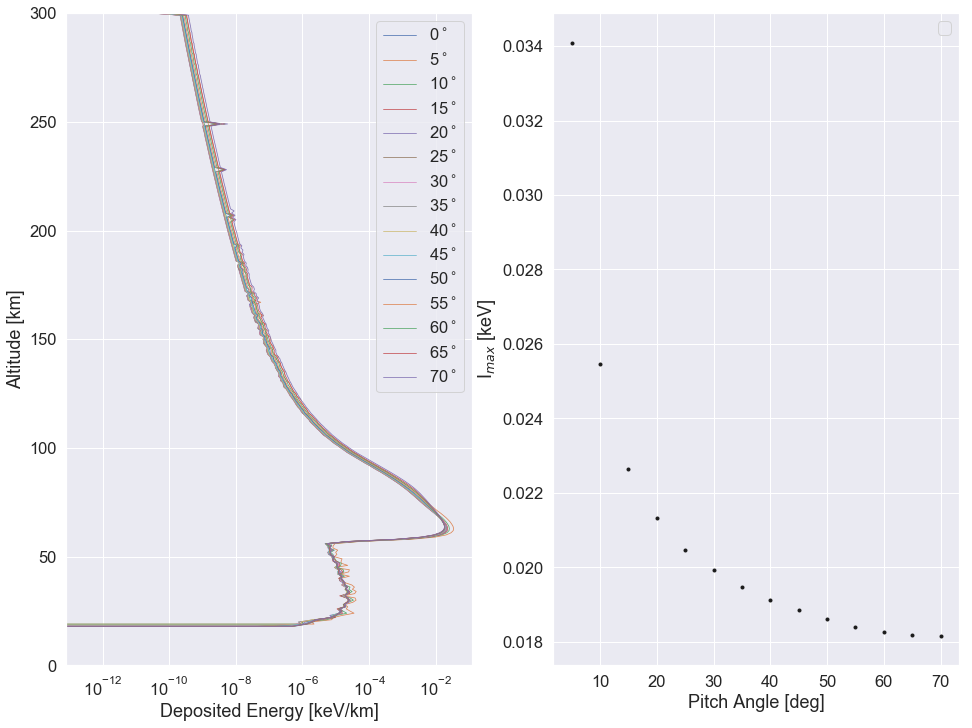

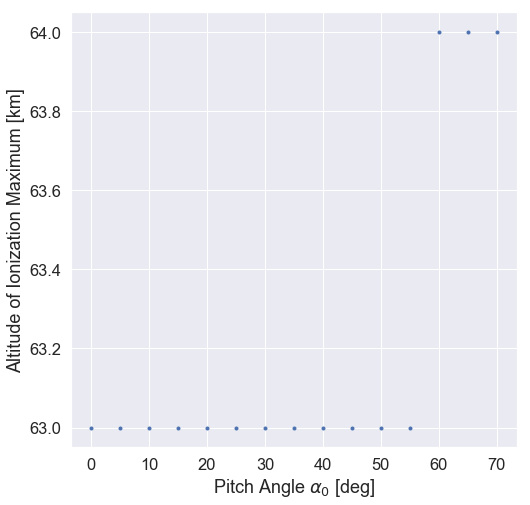

In [72]:
from scipy.signal import savgol_filter

energy = 1000

ang_end = np.max([int(x) for x in np.array(list(D_mono.keys()))[:,3]]) + 5

plt.figure(figsize=(16,12)); plt.subplot(1,2,1); plt.grid(True, which='both')
for i in range(0, ang_end, 5):
    if i % 5 == 0:
        label = '%.0f$^\circ$' % i
    else: 
        label = None
    plt.semilogx(D_mono[('electron', 'ioni', energy, i)][0] / (1e4*2*np.pi*np.sin(np.deg2rad(i))), h, 
                 label=label, linewidth=0.75)
    
    print("%.0f deg ~ %.3f keV/part" % 
          (i, np.sum(D_mono[('electron', 'ioni', energy, i)][0]) / (1e4*2*np.pi*np.sin(np.deg2rad(i)))))


plt.legend();
plt.ylim([0, 300]);
plt.ylabel('Altitude [km]');
plt.xlabel('Deposited Energy [keV/km]');


plt.subplot(1,2,2); plt.grid(True, which='both');
for i in range(0,ang_end,5):
    plt.plot(i, np.max(D_mono[('electron', 'ioni', energy, i)][0]/(1e4*2*np.pi*np.sin(np.deg2rad(i)))), 'k.')
        
plt.ylabel('I$_{max}$ [keV]');
plt.xlabel('Pitch Angle [deg]');
plt.legend();

plt.figure(figsize=(8,8));
for i in range(0, ang_end, 5):
    plt.plot(i, h[np.argmax(D_mono[('electron', 'ioni', energy, i)][0])], 'b.')
    
plt.xlabel(r'Pitch Angle $\alpha_0$ [deg]');
plt.ylabel('Altitude of Ionization Maximum [km]');

/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
No handles with labels found to put in legend.


0 deg ~ inf keV/part
5 deg ~ 2.424e-05 keV/part
10 deg ~ 1.832e-05 keV/part
15 deg ~ 1.652e-05 keV/part
20 deg ~ 1.561e-05 keV/part
25 deg ~ 1.500e-05 keV/part
30 deg ~ 1.483e-05 keV/part
35 deg ~ 1.462e-05 keV/part
40 deg ~ 1.471e-05 keV/part
45 deg ~ 1.465e-05 keV/part
50 deg ~ 1.478e-05 keV/part
55 deg ~ 1.501e-05 keV/part
60 deg ~ 1.524e-05 keV/part
65 deg ~ 1.552e-05 keV/part
70 deg ~ 1.572e-05 keV/part


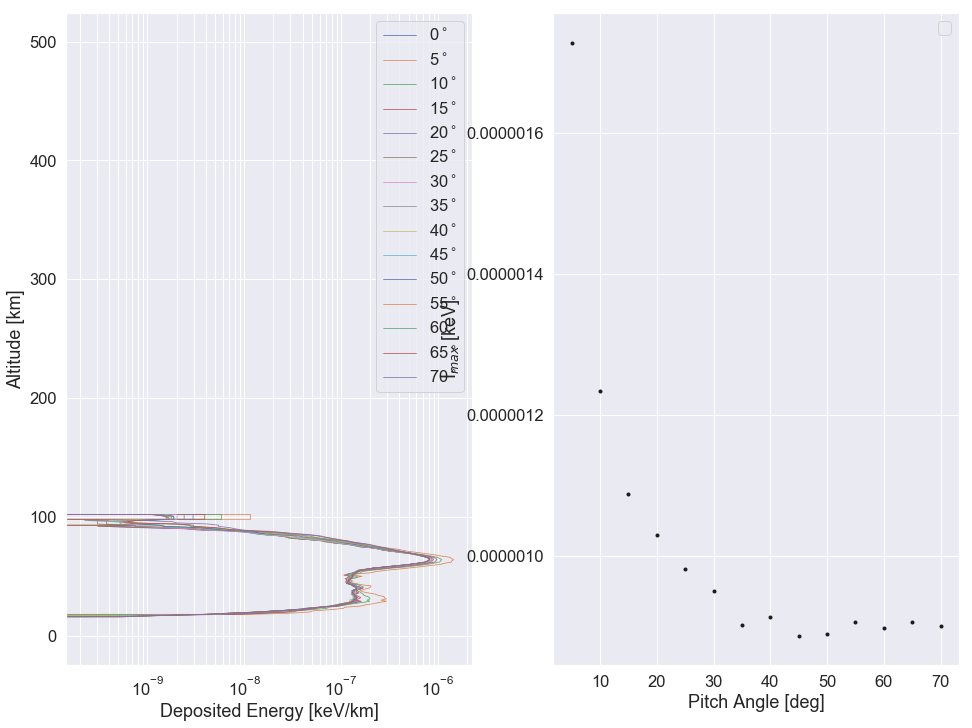

In [54]:
from scipy.signal import savgol_filter

energy = 1000


plt.figure(figsize=(16,12)); plt.subplot(1,2,1); plt.grid(True, which='both')
#for i in [0, 70]:
for i in range(0, ang_end, 5):
    if i % 5 == 0:
        label = '%.0f$^\circ$' % i
    else: 
        label = None
    plt.semilogx(savgol_filter(D_mono[('photon', 'ioni', energy, i)][0] /
                               (1e4*2*np.pi*np.sin(np.deg2rad(i))), 5, 0), h, 
                 label=label, linewidth=0.75)
    
    print("%.0f deg ~ %.3e keV/part" % 
          (i, np.sum(D_mono[('photon', 'ioni', energy, i)][0])/(1e4 * 2 * np.pi * np.sin(np.deg2rad(i)))))

plt.legend();
plt.ylabel('Altitude [km]');
plt.xlabel('Deposited Energy [keV/km]');


plt.subplot(1,2,2); plt.grid(True, which='both');

for i in range(0,ang_end,5):
    plt.plot(i, np.max(D_mono[('photon', 'ioni', energy, i)][0] / (1e4*2*np.pi*np.sin(np.deg2rad(i)))), 'k.')
        
    
plt.ylabel('I$_{max}$ [keV]');
plt.xlabel('Pitch Angle [deg]');
plt.legend();

/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


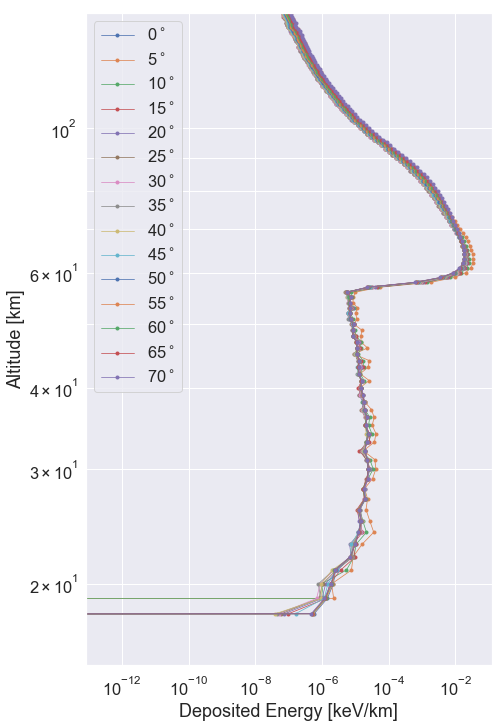

In [62]:
from scipy.signal import savgol_filter

energy = 1000


plt.figure(figsize=(16,12)); plt.subplot(1,2,1); plt.grid(True, which='both')
#for i in [0, 70]:
for i in range(0, ang_end, 5):
    if i % 5 == 0:
        label = '%.0f$^\circ$' % i
    else: 
        label = None
    plt.semilogx(savgol_filter(D_mono[('photon', 'ioni', energy, i)][0] +
                               D_mono[('electron', 'ioni', energy, i)][0], 1, 0) / 
                 (1e4 * 2 * np.pi *np.sin(np.deg2rad(i))), h, '.-',
                 label=label, linewidth=0.75)
    

plt.legend();
plt.yscale('log')
plt.ylim(1.5e1, 150)
#plt.yscale('log')
#plt.ylim([1e1, 300]);
#plt.xlim([1e-6, 1e4]);
plt.ylabel('Altitude [km]');
plt.xlabel('Deposited Energy [keV/km]');

/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide


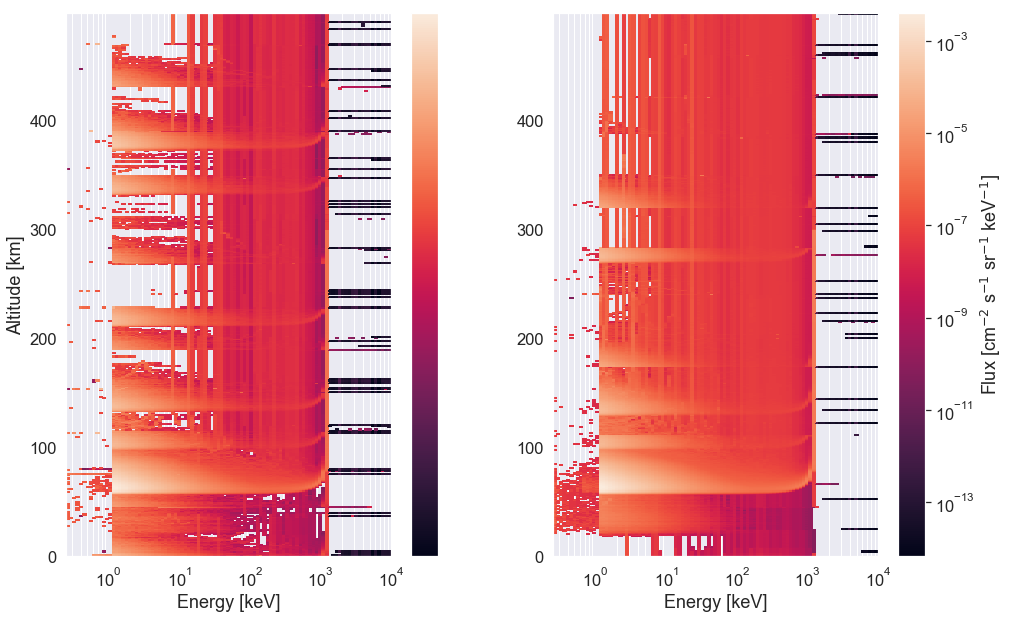

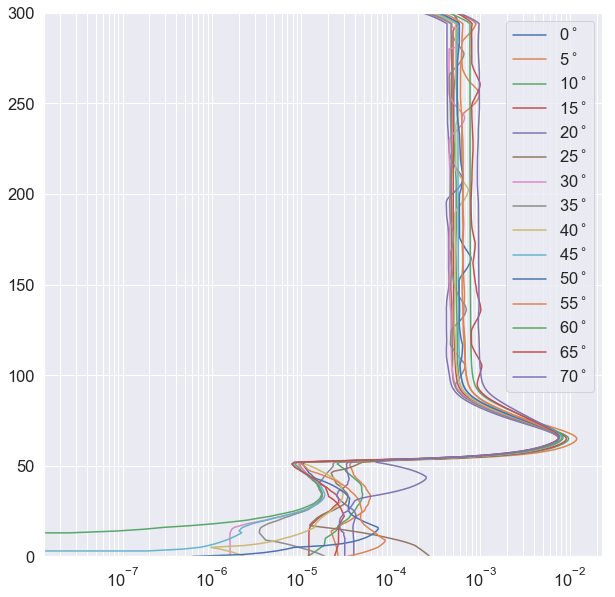

In [70]:
from matplotlib.colors import LogNorm

X,Y = np.meshgrid(Earray, h);


ang1 = 0

plt.figure(figsize=(16,10)); 
plt.subplot(1,2,1); plt.grid(True, which='both')
plt.pcolormesh(X, Y, D_mono[('electron', 'spectra', 1000, ang1)][0] / 
               (1e4 * 2 * np.pi * np.sin(np.rad2deg(i))), 
               norm=LogNorm());
plt.colorbar();
plt.xscale('log');
plt.xlabel('Energy [keV]');
plt.ylabel('Altitude [km]');

ang2 = 35

plt.subplot(1,2,2); plt.grid(True, which='both')
plt.pcolormesh(X, Y, D_mono[('electron', 'spectra', 1000, ang2)][0] / 
               (1e4 * 2 * np.pi * np.sin(np.rad2deg(ang2))), 
               norm=LogNorm());
plt.colorbar(label='Flux [cm$^{-2}$ s$^{-1}$ sr$^{-1}$ keV$^{-1}$]');
plt.xscale('log');
plt.xlabel('Energy [keV]');

plt.figure(figsize=(10,10)); plt.grid(True, which='both')
for i in range(0, ang_end, 5):
    plt.plot(savgol_filter(np.trapz(D_mono[('electron', 'spectra', 1000, i)][0], x=Earray), 11, 1)
             / (1e4 * 2 * np.pi * np.sin(np.deg2rad(i))),
             h, label='%.0f$^\circ$' % i)

#plt.hlines(79, 1e-2, 1e3, linewidth=1)
#plt.hlines(78, 1e-2, 1e3, linewidth=1)
plt.xscale('log');
plt.ylim(0, 300);
plt.legend();